<a href="https://colab.research.google.com/github/SrivenkateswaraRao/Research-Project/blob/master/Pest_Classifier_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from os import listdir
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import files
files.upload() 

In [ ]:
import CreatePestImageData as Imagedataset
import SupportingFunctions as support

In [ ]:
support.DownLoadFiles('1aXb25Wp9sG7mL6AQgYY9ElrGcERi95JU',drive)

In [ ]:
support.Unzip('/content/GREENPATROL_DB_V3.0.zip','/content/Pests/Images')

In [ ]:
support.fileCount('/content/Pests/Images')

4330


In [ ]:
dataSet = Imagedataset.createImageDataset()

In [ ]:
class_object = {0 : 'egg_wf' ,
                1 : 'egg_bt', 2 : 'egg_ta', 3 : 'wf', 4 : 'bt', 5 : 'tomato'}

In [ ]:
dataSet.prepare_dataset('/content/Pests/Labels' , class_object ,32, '/content/Pests/Images',  test_size=11241 )

In [ ]:
listdir('/content/Pests/Labels')

In [ ]:
(trainY , trainX) , (testY , testX ) = (dataSet.trainY , dataSet.trainX ) , (dataSet.testY , dataSet.testX )


In [ ]:
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
import tensorflow as tf

In [ ]:
from keras import backend as K
if K.image_data_format() == 'channels_first':
   input_shape = [3, 75, 75]
else:
   input_shape = [75, 75, 3]

In [ ]:
import tensorflow as tf
from keras import models
from keras.applications.inception_v3 import InceptionV3
InceptionV3 = InceptionV3(input_shape=input_shape, include_top=False, pooling='avg',weights='imagenet')
InceptionV3.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 37, 37, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 37, 37, 32)   0           batch_normalization_1[0][0]      
______________________

In [ ]:
from keras.models import Model
layerName = 'conv2d_3'
mymodel = Model(inputs= InceptionV3.input , outputs=InceptionV3.get_layer(layerName).output)
mymodel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 32)        864       
_________________________________________________________________
batch_normalization_1 (Batch (None, 37, 37, 32)        96        
_________________________________________________________________
activation_1 (Activation)    (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 35, 32)        9216      
_________________________________________________________________
batch_normalization_2 (Batch (None, 35, 35, 32)        96        
_________________________________________________________________
activation_2 (Activation)    (None, 35, 35, 32)        0   

In [ ]:
from keras import applications
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt

In [ ]:
model= models.Sequential()
model.add(mymodel)
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(6, activation='softmax'))
model.layers[0].trainable = True

# compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 35, 35, 64)        28704     
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 35, 35, 16)        9232      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 16)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 17, 17, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

In [ ]:
from tensorflow.keras.utils import to_categorical
trainY = to_categorical(trainY)
testY = to_categorical(testY)

In [ ]:
filepath="/content/drive/My Drive/Models/InceptionV3/weights-{epoch:02d}-{accuracy:.3f}.hdf5"
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='accuracy',
                               verbose=1, mode='max',save_best_only=True)

callbacks_list = [checkpoint]

In [ ]:
tf.config.experimental_run_functions_eagerly(True)


In [ ]:
model.fit(trainX,trainY,verbose=1,epochs=50,validation_data=(testX,testY),callbacks=[checkpoint])

Train on 44964 samples, validate on 11241 samples
Epoch 1/50
44964/44964 [==============================] - 96s 2ms/step - loss: 0.9010 - accuracy: 0.6476 - val_loss: 1.3446 - val_accuracy: 0.5509

Epoch 00001: accuracy improved from -inf to 0.64763, saving model to /content/drive/My Drive/Models/InceptionV3/weights-01-0.648.hdf5
Epoch 2/50
44964/44964 [==============================] - 93s 2ms/step - loss: 0.8159 - accuracy: 0.6724 - val_loss: 0.8883 - val_accuracy: 0.6568

Epoch 00002: accuracy improved from 0.64763 to 0.67243, saving model to /content/drive/My Drive/Models/InceptionV3/weights-02-0.672.hdf5
Epoch 3/50
44964/44964 [==============================] - 92s 2ms/step - loss: 0.7888 - accuracy: 0.6822 - val_loss: 0.7508 - val_accuracy: 0.6982

Epoch 00003: accuracy improved from 0.67243 to 0.68217, saving model to /content/drive/My Drive/Models/InceptionV3/weights-03-0.682.hdf5
Epoch 4/50
44964/44964 [==============================] - 92s 2ms/step - loss: 0.7752 - accuracy: 

In [ ]:
import json
history_dict = model.history.history
json.dump(str(history_dict), open('/content/drive/My Drive/Models/InceptionV3/History/InceptionV3_History1.json', 'w'))

In [ ]:
acc = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']
loss  =  model.history.history['loss']
val_loss = model.history.history['val_loss']

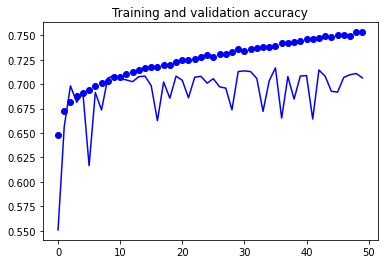

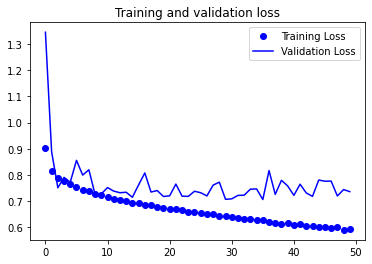

In [ ]:
support.GenerateGraphs(acc,val_accuracy,loss,val_loss)


In [ ]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
   
  plt.imshow(img[...,0], cmap=plt.cm.binary)
 
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
   
  plt.xlabel("{} {:2.0f}% ({})".format(class_object[predicted_label],
                                100*np.max(predictions_array),
                                class_object[true_label]),
                                color=color)

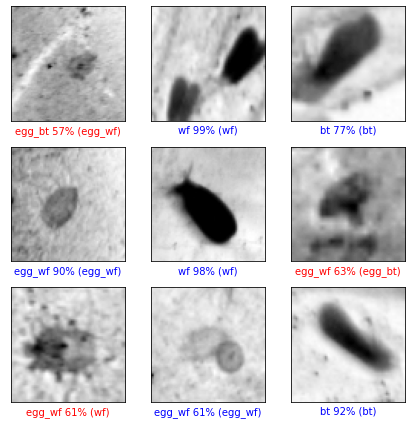

In [ ]:
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*num_cols, 2*num_rows))
test_images = testX[:num_images]
predictions = model.predict(testX_Pred)
for i in range(num_images):    
    plt.subplot(num_rows, num_cols, i+1)   
    plot_image(i, predictions, testY_Pred, testX_Pred)    
 
plt.tight_layout()
plt.show()

In [ ]:
support.PrintMetrics(testX_Pred,testY_Pred,model)

Accuracy: 0.706432
Precision: 0.697948
Recall: 0.659456
F1 score: 0.658780
Cohens kappa: 0.543936
